3D volumetric rendering using NeRF.
- each ray passes through a 3D field of densities mu(x,y,z)
- we render an image by evaluating one ray per pixel
- I = exp - sum_i mu_i delta_s_i

1: Define a 3D voxel density field mu(x,y,z)
- basically, a set of objects with densities in a 3D volume

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# --- Volume definition (your existing mu) ---
Nx, Ny, Nz = 64, 64, 64
mu = np.zeros((Nx, Ny, Nz), dtype=np.float32)

# cube 1
mu1 = 0.1
mu[0:20, 0:20, 0:30] = mu1

# cube 2
mu2 = 0.5
mu[30:35, 30:35, 0:30] = mu2

# sphere
mu3 = 0.3
cx, cy, cz, r = 48, 48, 48, 10
X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), np.arange(Nz), indexing='ij')
sphere = (X - cx)**2 + (Y - cy)**2 + (Z - cz)**2 <= r**2
mu[sphere] = mu3

1.1: Show the density volume in 3D

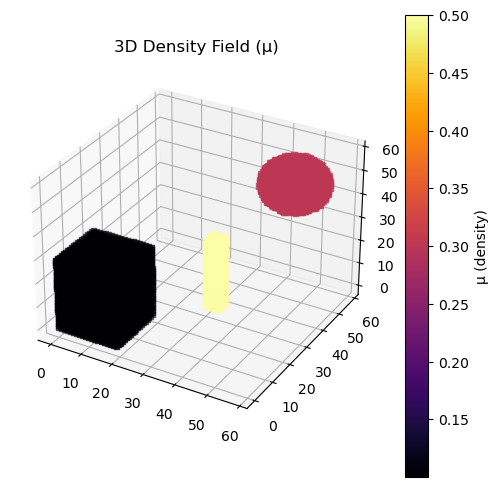

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# pick voxels with density > 0
x, y, z = np.nonzero(mu)
c = mu[x, y, z]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(x, y, z, c=c, cmap='inferno', marker='s', s=15)
plt.colorbar(p, ax=ax, label='μ (density)')
ax.set_title("3D Density Field (μ)")
plt.show()


2: Generate a grid of rays
- each ray starts from a side (camera plane) and points inward toward the cube center

In [50]:
import numpy as np

def generate_camera_rays(view_origin, view_dir, up_vec, fov_size, res, distance, volume_shape):
    """
    Generate a grid of rays forming a square image from a given viewpoint.

    view_origin: 3D point of camera center (in world coordinates)
    view_dir:    direction the camera is facing (unit vector)
    up_vec:      camera up direction (unit vector)
    fov_size:    size of the image plane (world units)
    res:         (H, W) resolution of the grid
    distance:    distance from camera to image plane
    volume_shape: (Nx, Ny, Nz) for centering the volume
    """
    H, W = res
    center = np.array(volume_shape) / 2

    # Build orthonormal camera basis
    w = -view_dir / np.linalg.norm(view_dir)
    u = np.cross(up_vec, w)
    u /= np.linalg.norm(u)
    v = np.cross(w, u)

    # Image plane coordinates
    xs = np.linspace(-fov_size/2, fov_size/2, W)
    ys = np.linspace(-fov_size/2, fov_size/2, H)
    X, Y = np.meshgrid(xs, ys)

    # Points on the image plane in world space
    plane_center = view_origin - w * distance
    origins = plane_center + X[...,None]*u + Y[...,None]*v
    directions = np.tile(view_dir, (H*W, 1))

    return origins.reshape(-1,3), directions


2.1: Generate multiple views by rotating around the volume

In [80]:
# Volume and rendering setup
Nx, Ny, Nz = mu.shape
res = (64, 64)
fov_size = 2 * Nx
distance = 4 * Nx  # camera distance
num_views = 8

# Generate viewpoints in a circle around the volume
angles = np.linspace(0, np.pi, num_views, endpoint=False)
all_origins, all_dirs = [], []

for theta in angles:
    cam_pos = np.array([
        Nx/2 + distance*np.cos(theta),
        Ny/2 + distance*np.sin(theta),
        Nz/2])
    view_dir = (np.array([Nx/2, Ny/2, Nz/2]) - cam_pos)
    view_dir /= np.linalg.norm(view_dir)
    up = np.array([0, 0, 1])
    origins, directions = generate_camera_rays(
        cam_pos, view_dir, up, 
        fov_size,
        res,
        distance,
        mu.shape)
    all_origins.append(origins)
    all_dirs.append(directions)


In [81]:
print(all_origins[0].shape)
print(all_dirs[0].shape)

(4096, 3)
(4096, 3)


3: March rays through the voxel grid
- for each ray, sample along its path and integrate the attenuation

In [82]:
def render_volume(mu, origins, directions, step=1.0):
    Nx, Ny, Nz = mu.shape
    img = np.zeros(len(origins))
    for i, (o, d) in enumerate(zip(origins, directions)):
        intensity = 1.0 # I_s = 1.0
        pos = o.copy()
        # check out-of-bounds
        while 0 <= pos[0] < Nx and 0 <= pos[1] < Ny and 0 <= pos[2] < Nz:
            ix, iy, iz = np.floor(pos).astype(int)
            intensity *= np.exp(-mu[ix, iy, iz] * step)
            pos += d * step
        img[i] = intensity
    return img

4: Render the attenuation image for each view

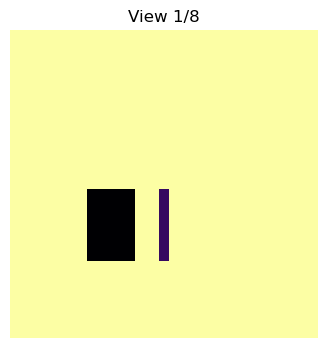

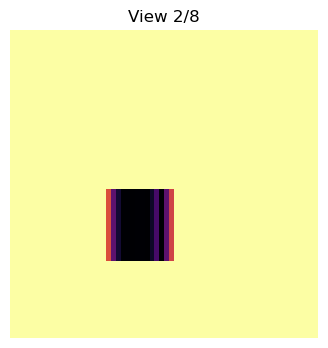

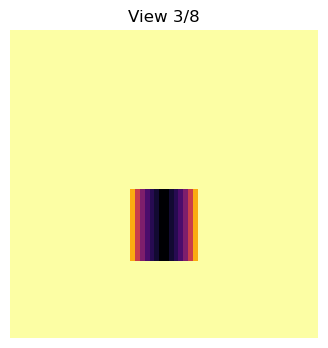

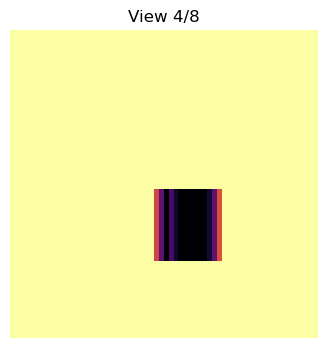

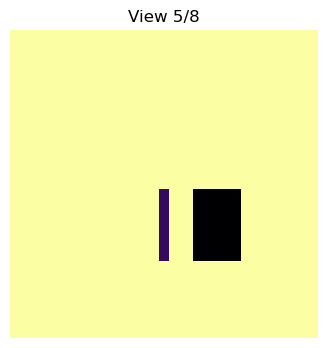

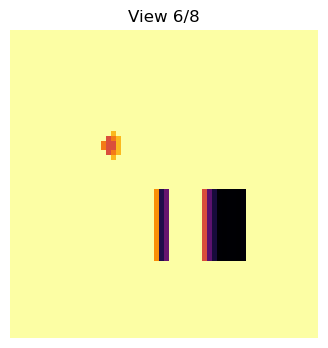

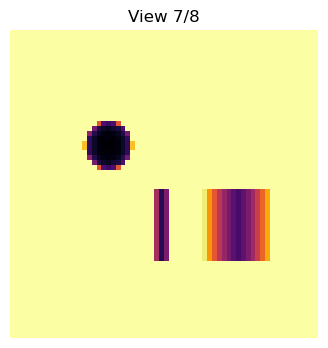

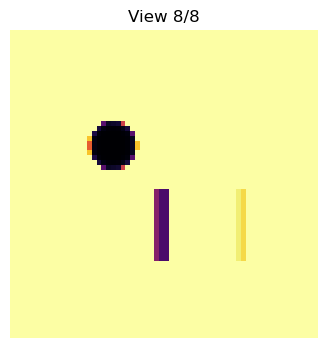

In [79]:
import matplotlib.pyplot as plt

for k, (origins, dirs) in enumerate(zip(all_origins, all_dirs)):
    img = render_volume(mu, origins, dirs, step=0.5).reshape(res)
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='inferno', origin='lower')
    plt.title(f"View {k+1}/{num_views}")
    plt.axis('off')
    plt.show()
